# Estimating reference expression signatures of cell types

## liver reference, lowQ excluded

## Outline

The **cell2location** workflow consists of three sections:

I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. [Loading single cell reference data](#1.-Loading-single-cell-reference-data)
2. [Reduce the number of genes by discarding lowly expressed genes](#2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes)
3. [Exploring the data: show UMAP of cells](#3.-Show-UMAP-of-cells)
4. [Estimating expression signatures](#4.-Estimating-expression-signatures)
5. [Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow](#5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow)

II. Spatially mapping cell types (2/3)

III. Results and downstream analysis (3/3)

![**cell2location** workflow](https://raw.githubusercontent.com/BayraktarLab/cell2location/master/docs/images/FigS1_cell2location_workflow.png)



## Loading packages

First, we need to load the relevant packages. Regression model for estimating expression signatures of cell types cell2location is written in pytorch. While the package works on both GPU and CPU, using the GPU shortens the computation time by ~8 times to just a few minutes.

In [1]:
import sys,os

#if branch is stable, will install via pypi, else will install from source
#branch = "pyro-cell2location"
#user = "vitkl"
#IN_COLAB = "google.colab" in sys.modules

#if IN_COLAB and branch == "stable":
#    !pip install --quiet scvi-tools[tutorials]
#elif IN_COLAB and branch != "stable":
#    !pip install --quiet --upgrade jsonschema
#    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]
        
#import sys
#if not IN_COLAB:
# sys.path.insert(1, '/home/jupyter/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import torch
#torch.cuda.set_device('cuda:1')
torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count()

(True, 0, 1)

## 1. Loading single cell reference data <a name="1.-Loading-single-cell-reference-data"></a>

In [2]:
sc_data_folder = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/c2l_scRNA_references/'
sc_data_h5ad = 'PAN.A01.v01.c2l_reference.v2.subsetLI.exclude_lowQ.h5ad'
results_folder = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/c2l_results/'

if not os.path.exists(results_folder):
    os.mkdir(results_folder)
scvi_run_name = f'{results_folder}signatures_{sc_data_h5ad.rstrip(".h5ad")}'

Now, we load the pre-processed snRNAseq reference. Scanpy website has tutorials covering how to import other formats.

In [3]:
## snRNA reference (raw counts)
adata = anndata.read_h5ad(sc_data_folder + sc_data_h5ad)

In [4]:
# remove "/" from cell types to avoid anndata save issues
from re import sub
adata.obs['anno_c2l'] = [sub('/', '_', i) for i in adata.obs['anno_c2l']]

In [5]:
adata.layers, adata.raw

(Layers with keys: , None)

In [6]:
adata.obs

,method,donor,Sample.lanes,anno_c2l,organ,age
FCAImmP7198630-CTAGTGAGTCGAATCT,3GEX,F23,FCAImmP7198630,EARLY_ERY,LI,11
FCAImmP7198630-GCTCTGTCACTTAAGC,3GEX,F23,FCAImmP7198630,EARLY_ERY,LI,11
FCAImmP7198630-TTCTCCTTCTTGCATT,3GEX,F23,FCAImmP7198630,EARLY_ERY,LI,11
FCAImmP7198630-CGTCCATGTATAGGGC,3GEX,F23,FCAImmP7198630,MEP,LI,11
FCAImmP7198630-CTCCTAGCAGTGGGAT,3GEX,F23,FCAImmP7198630,EARLY_ERY,LI,11
...,...,...,...,...,...,...
FCAImmP7198628-GCTGCGAGTCGAACAG,3GEX,F22,FCAImmP7198628,LOW_QUALITY_MACROPHAGE,LI,9
FCAImmP7198628-ACGGAGAAGTGTCCAT,3GEX,F22,FCAImmP7198628,MACROPHAGE_VII_ERY,LI,9
FCAImmP7198628-TGACGGCAGCGACGTA,3GEX,F22,FCAImmP7198628,MACROPHAGE_VII_ERY,LI,9
FCAImmP7198628-GTCCTCAAGCCACGCT,3GEX,F22,FCAImmP7198628,LOW_QUALITY_MACROPHAGE,LI,9


In [7]:
# checking that data is integer counts
adata.X.data

array([11.,  1.,  2., ...,  1.,  2.,  1.], dtype=float32)

## 2. Reduce the number of genes by discarding lowly expressed genes <a name="2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes"></a>

This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG) which is prone to deleting markers of rare populations.

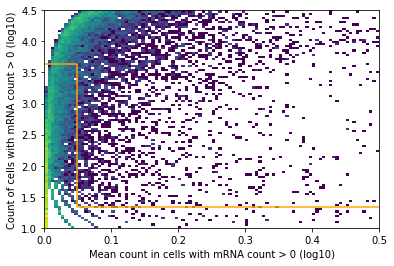

In [8]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata.var['n_cells'] = np.array((adata.X > 0).sum(0)).flatten()
adata.var['nonz_mean'] = np.array(adata.X.sum(0)).flatten() \
/ adata.var['n_cells']

plt.hist2d(np.log10(adata.var['nonz_mean']),
           np.log10(adata.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata.shape[0] * 0.0001) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata.shape[0] * 0.02)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

Show the number of selected cells and genes:

In [9]:
adata[:,(np.array(np.log10(adata.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff)].shape

(216748, 14543)

Filter the object:

In [10]:
# select genes based on mean expression in non-zero cells
adata = adata[:,(np.array(np.log10(adata.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff)].copy()

Add counts matrix as `adata.raw` 

In [11]:
adata.var

,GeneID,GeneName,n_cells,nonz_mean
TSPAN6,ENSG00000000003,TSPAN6,37262,1.731040
TNMD,ENSG00000000005,TNMD,117,1.940171
DPM1,ENSG00000000419,DPM1,84425,1.953545
SCYL3,ENSG00000000457,SCYL3,12512,1.060662
C1orf112,ENSG00000000460,C1orf112,21786,1.174883
...,...,...,...,...
AL034549.1,ENSG00000285230,AL034549.1,8428,1.049834
AC090517.4,ENSG00000285253,AC090517.4,5188,1.063608
ATXN7-1,ENSG00000285258,ATXN7,4344,1.024401
POLR2J3-1,ENSG00000285437,POLR2J3,73791,1.741811


## 4. Estimating expression signatures  <a name="4.-Estimating-expression-signatures"></a> 

### Brief description of the model

**Model-based estimation of reference expression signatures of cell types $g_{f,g}$ using a regularised Negative Binomial regression.** This model robustly derives reference expression signatures of cell types $g_{f,g}$ using the data composed of multiple batches $e=\{1..E\}$ and technologies $t=\{1..T\}$. Adapting the assumptions of a range of computational methods for scRNA-seq, we assume that the expression count matrix follows a Negative Binomial distribution with unobserved expression levels (rates) $\mu_{c,g}$ and a gene-specific over-dispersion $\alpha_g$. We model $\mu_{c,g}$ as a linear function of reference cell type signatures and technical effects:
- $e_e$ denotes a multiplicative global scaling parameter between experiments/batches $e$ (e.g. differences in sequencing depth);
- $t_{t,g}$ accounts for multiplicative gene-specific difference in sensitivity between technologies; 
- $b_{e,g}$ accounts for additive background shift of each gene in each experiment $e$ (proxy for free-floating RNA).

### Training the model

Here we show how to perform the training of this model wrapped into a singe pipeline function call, how to assess the quality of this model and extract reference signatures of cell types for use with cell2location:

In [12]:
adata.obs['anno_c2l'].value_counts()[::-1][0:20]

EPITHELIUM_II           20
DP(P)_T                 20
DN(P)_T                 20
CYCLING_EPITHELIUM      22
FIBROBLAST_IV           23
LMPP_ELP                24
DN(early)_T             24
MIGRATORY_DC            27
GLIAL                   37
ILC2                    40
VSMC                    62
MUSCLE_SATELLITE        74
PRE_DC2                 75
CYCLING_MPP             77
AS_DC                   77
CYCLING_FIBROBLAST_I    80
CD8AA                   81
ENDOTHELIUM_I           85
FIBROBLAST_IX           86
CYCLING_B               95
Name: anno_c2l, dtype: int64

In [13]:
# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata, batch_key='Sample.lanes', labels_key='anno_c2l',
                        categorical_covariate_keys=['method', 'donor']
                       )
scvi.data.view_anndata_setup(adata)

INFO     Using batches from adata.obs["Sample.lanes"]                                        
INFO     Using labels from adata.obs["anno_c2l"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 216748 cells, 14543 vars, 47      
         batches, 87 labels, and 0 proteins. Also registered 2 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.13.0.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 216748 │
│             Vars             │ 14543  │
│            Labels            │   87   │
│           Batches            │   47   │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   2    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │                adata.X                 │
│ batch_indices │        adata.obs['_scvi_batch']        │
│ local_l_mean  │    adata.obs['_scvi_local_l_mean']     │
│  local_l_var  │     adata.obs['_scvi_local_l_var']     │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
└───────────────┴────────────────────────────────────────┘

                                Label Categories                                 
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['anno_c2l'] │              AS_DC              │          0          │
│                       │               B1                │          1          │
│                       │              CD4+T              │          2          │
│                       │              CD8+T              │          3          │
│                       │              CD8AA              │          4          │
│                       │               CMP               │          5          │
│                       │            CYCLING_B            │          6          │
│                       │           CYCLING_DC2           │          7          │
│                       │           CYCLING_DC3           │          8          │
│                       │       CYCLING_EPITHELIUM        │          9          │
│                       │      CYCLING_FIBROBLAST_I       │         10          │
│                       │           CYCLING_ILC           │         11          │
│                       │          CYCLING_MEMP           │         12          │
│                       │           CYCLING_MPP           │         13          │
│                       │           CYCLING_NK            │         14          │
│                       │           CYCLING_PDC           │         15          │
│                       │            CYCLING_T            │         16          │
│                       │               DC1               │         17          │
│                       │               DC2               │         18          │
│                       │               DC3               │         19          │
│                       │          DC_PROGENITOR          │         20          │
│                       │             DN(P)_T             │         21          │
│                       │           DN(early)_T           │         22          │
│                       │             DP(P)_T             │         23          │
│                       │            EARLY_ERY            │         24          │
│                       │            EARLY_MK             │         25          │
│                       │          ENDOTHELIUM_I          │         26          │
│                       │         ENDOTHELIUM_IV          │         27          │
│                       │       EOSINOPHIL_BASOPHIL       │         28          │
│                       │          EPITHELIUM_II          │         29          │
│                       │              ERY_I              │         30          │
│                       │          FIBROBLAST_IV          │         31          │
│                       │          FIBROBLAST_IX          │         32          │
│                       │          FIBROBLAST_XI          │         33          │
│                       │              GLIAL              │         34          │
│                       │               GMP               │         35          │
│                       │         HEPATOCYTE-LIKE         │         36          │
│                       │          HEPATOCYTE_I           │         37          │
│                       │          HEPATOCYTE_II          │         38          │
│                       │            HIGH_MITO            │         39          │
│                       │             HSC_MPP             │         40          │
│                       │              ILC2               │         41          │
│                       │              ILC3               │         42          │
│                       │           IMMATURE_B            │         43          │
│                       │           LARGE_PRE_B           │     

                          Batch Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample.lanes'] │ FCAImmP7179363 │          0          │
│                           │ FCAImmP7179364 │          1          │
│                           │ FCAImmP7198434 │          2          │
│                           │ FCAImmP7198628 │          3          │
│                           │ FCAImmP7198629 │          4          │
│                           │ FCAImmP7198630 │          5          │
│                           │ FCAImmP7198631 │          6          │
│                           │ FCAImmP7241242 │          7          │
│                           │ FCAImmP7241243 │          8          │
│                           │ FCAImmP7277552 │          9          │
│                           │ FCAImmP7277553 │         10          │
│                           │ FCAImmP7277560 │         11          │
│                           │ FCAImmP7277561 │         12          │
│                           │ FCAImmP7292028 │         13          │
│                           │ FCAImmP7292032 │         14          │
│                           │ FCAImmP7316889 │         15          │
│                           │ FCAImmP7316890 │         16          │
│                           │ FCAImmP7316891 │         17          │
│                           │ FCAImmP7316892 │         18          │
│                           │ FCAImmP7316893 │         19          │
│                           │ FCAImmP7316894 │         20          │
│                           │ FCAImmP7316895 │         21          │
│                           │ FCAImmP7316901 │         22          │
│                           │ FCAImmP7352192 │         23          │
│                           │ FCAImmP7352193 │         24          │
│                           │ FCAImmP7352194 │         25          │
│                           │ FCAImmP7352195 │         26          │
│                           │ FCAImmP7352196 │         27          │
│                           │ FCAImmP7462238 │         28          │
│                           │ FCAImmP7462239 │         29          │
│                           │ FCAImmP7528286 │         30          │
│                           │ FCAImmP7528287 │         31          │
│                           │ FCAImmP7528288 │         32          │
│                           │ FCAImmP7528289 │         33          │
│                           │ FCAImmP7528295 │         34          │
│                           │ FCAImmP7555846 │         35          │
│                           │ FCAImmP7555847 │         36          │
│                           │ FCAImmP7555856 │         37          │
│                           │ FCAImmP7555857 │         38          │
│                           │ FCAImmP7579222 │         39          │
│                           │ FCAImmP7579223 │         40          │
│                           │ FCAImmP7579226 │         41          │
│                           │ FCAImmP7579227 │         42          │
│                           │ FCAImmP7862084 │         43          │
│                           │ FCAImmP7862085 │         44          │
│                           │ FCAImmP7862086 │         45          │
│                           │ FCAImmP7862087 │         46          │
└───────────────────────────┴────────────────┴─────────────────────┘

               Extra Categorical Variables                
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
│ adata.obs['donor']  │    F19     │          0          │
│                     │    F21     │          1          │
│                     │    F22     │          2          │
│                     │    F23     │          3          │
│                     │    F29     │          4          │
│                     │    F30     │          5          │
│                     │    F32     │          6          │
│                     │    F33     │          7          │
│                     │    F34     │          8          │
│                     │    F35     │          9          │
│                     │    F38     │         10          │
│                     │    F41     │         11          │
│                     │    F45     │         12          │
│                     │    F61     │         13          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [ ]:
# create and train the model
import pyro
from cell2location.models import RegressionModel
mod = RegressionModel(
    adata,
    #amortised=True, encoder_mode="single",
    #encoder_kwargs={'dropout_rate': 0.1}
) 

mod.train(max_epochs=200, 
          batch_size=2500, 
          train_size=1,
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(50)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata = mod.export_posterior(
    adata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}signatures_200epochs", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}", adata)

# Save anndata object with results
adata_file = f"{scvi_run_name}signatures_200epochs/sc.h5ad"
adata.write(adata_file)
adata_file

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling local variables, batch:  93%|█████████▎| 81/87 [27:48<02:03, 20.59s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:19<00:00, 51.03it/s]


'/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/c2l_results/signatures_PAN.A01.v01.c2l_reference.v2.subsetLI.exclude_lowQ_400epochs/sc.h5ad'

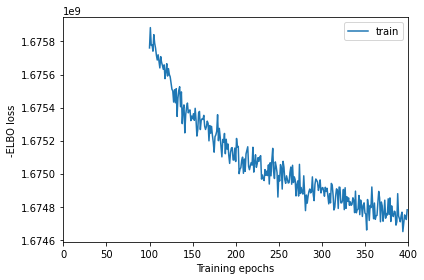

In [19]:
# scvi_run_name = f'{results_folder}signatures_400epochs'

mod.train(max_epochs=200, 
          batch_size=2500, 
          train_size=1,
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(100)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata = mod.export_posterior(
    adata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}_400epochs", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}", adata)

# Save anndata object with results
adata_file = f"{scvi_run_name}_400epochs/sc.h5ad"
adata.write(adata_file)
adata_file

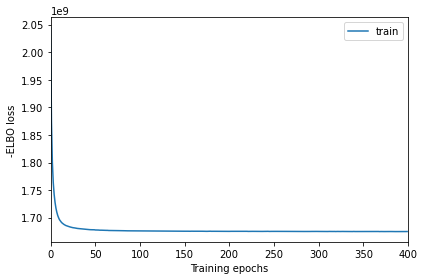

In [21]:
mod.plot_history()

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

In [22]:
mod.plot_QC()

ValueError: shapes (1000,15) and (16,14543) not aligned: 15 (dim 1) != 16 (dim 0)

Modules and their versions used for this analysis

In [23]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.10 | packaged by conda-forge | (default, Oct  5 2021, 17:08:41) 
[GCC 9.4.0]
ipykernel 6.4.1
ipykernel._version 6.4.1
re 2.2.1
json 2.0.9
jupyter_client 7.0.6
jupyter_client._version 7.0.6
traitlets 5.1.0
traitlets._version 5.1.0
logging 0.5.1.2
zmq 22.3.0
platform 1.0.8
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.3.0
zmq.sugar.constants 40304
zmq.sugar.version 22.3.0
argparse 1.1
tornado 6.1
zlib 1.0
colorama 0.4.4
_curses b'2.2'
dateutil 2.8.2
dateutil._version 2.8.2
six 1.16.0
decimal 1.70
_decimal 1.70
jupyter_core 4.8.1
jupyter_core.version 4.8.1
entrypoints 0.3
IPython 7.28.0
IPython.core.release 7.28.0
IPython.core.crashhandler 7.28.0
pygments 2.10.0
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.1.0
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.20
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
IPython.core.magics.code 7.28.0
urllib.request 3.7
ipython_genutils 0.2.0
ipytho